# Word2Vec

Let's work on skipgram-based implementation of word2vec.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

## 1. Download nltk corpus

In [1]:
import nltk
from nltk.corpus import reuters

In [21]:
nltk.download('reuters')
nltk.download('punkt')

[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\sung2_8l7o06c\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\sung2_8l7o06c\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
corpus = nltk.corpus.reuters.sents()

In [3]:
len(corpus)

54716

In [23]:
#get word sequences and unique words
flatten = lambda l: [item for sublist in l for item in sublist]
vocab = list(set(flatten(corpus)))

In [24]:
#append UNK
vocab.append('<UNK>')

In [25]:
#numericalization
word2index = {w: i for i, w in enumerate(vocab)}

In [ ]:
import pickle
pickle.dump(vocab, open('./vocab/word2vec_vocab.pkl', 'wb'))

In [26]:
#vocab size
voc_size = len(vocab)
print(voc_size)

41600


In [27]:
#just in case we need to use
index2word = {v:k for k, v in word2index.items()}

## 2. Prepare train data

In [28]:
# for c in corpus:
#     print(c)

In [29]:
def random_batch(batch_size, word_sequence):

    # Make skip gram of a window size of 2
    skip_grams = []
    # loop each word sequence
    # we starts from 2 because 0 and 1 have no/not enough context
    # we stop at third last for the same reason
    for sent in corpus:
        for i in range(2, len(sent) - 2):
            target = word2index[sent[i]]
            context = [word2index[sent[i - 2]], word2index[sent[i - 1]], word2index[sent[i + 1]], word2index[sent[i + 2]]]
            for w in context:
                skip_grams.append([target, w])

    random_inputs = []
    random_labels = []
    random_index = np.random.choice(range(len(skip_grams)), batch_size, replace=False) #randomly pick without replacement

    for i in random_index:
        random_inputs.append([skip_grams[i][0]])  # target, e.g., 2
        random_labels.append([skip_grams[i][1]])  # context word, e.g., 3

    return np.array(random_inputs), np.array(random_labels)

### Testing the method

In [30]:
#testing the method
batch_size = 2 # mini-batch size
input_batch, target_batch = random_batch(batch_size, corpus)

print("Input: ", input_batch)
print("Target: ", target_batch)

#we will convert them to tensor during training, so don't worry...

Input:  [[17356]
 [27547]]
Target:  [[ 5412]
 [11839]]


## 3. Skipgram

$$J(\theta) = -\frac{1}{T}\sum_{t=1}^{T}\sum_{\substack{-m \leq j \leq m \\ j \neq 0}}\log P(w_{t+j} | w_t; \theta)$$

where $P(w_{t+j} | w_t; \theta) = $

$$P(o|c)=\frac{\exp(\mathbf{u_o^{\top}v_c})}{\sum_{w=1}^V\exp(\mathbf{u_w^{\top}v_c})}$$

where $o$ is the outside words and $c$ is the center word

In [3]:
class Skipgram(nn.Module):

    def __init__(self, vocab_size, emb_size):
        super(Skipgram,self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size)
        self.embedding_u = nn.Embedding(vocab_size, emb_size)

    def forward(self, center_words, target_words, all_vocabs):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        all_embeds    = self.embedding_u(all_vocabs) #   [batch_size, voc_size, emb_size]

        scores      = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        norm_scores = all_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, voc_size, emb_size] @ [batch_size, emb_size, 1] = [batch_size, voc_size, 1] = [batch_size, voc_size]

        nll = -torch.mean(torch.log(torch.exp(scores)/torch.sum(torch.exp(norm_scores), 1).unsqueeze(1))) # log-softmax
        # scalar (loss must be scalar)

        return nll # negative log likelihood

### Training

In [32]:
batch_size     = 2 # mini-batch size
embedding_size = 2 # so we can later plot
model          = Skipgram(voc_size, embedding_size)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [33]:
def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

#use for the normalized term in the probability calculation
all_vocabs = prepare_sequence(list(vocab), word2index).expand(batch_size, len(vocab))  # [batch_size, voc_size]
all_vocabs.shape

torch.Size([2, 41600])

In [34]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
import time

# Training
num_epochs = 100
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch = random_batch(batch_size, corpus)
    input_batch  = torch.LongTensor(input_batch)  #[batch_size, 1]
    target_batch = torch.LongTensor(target_batch) #[batch_size, 1]

    optimizer.zero_grad()
    loss = model(input_batch, target_batch, all_vocabs)

    loss.backward()
    optimizer.step()

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 10 | cost: 10.805967 | time: 0m 9s
Epoch: 20 | cost: 12.732189 | time: 0m 10s
Epoch: 30 | cost: 11.166786 | time: 0m 9s
Epoch: 40 | cost: 10.011631 | time: 0m 10s
Epoch: 50 | cost: 10.459942 | time: 0m 11s
Epoch: 60 | cost: 11.574034 | time: 0m 10s
Epoch: 70 | cost: 10.787571 | time: 0m 11s
Epoch: 80 | cost: 12.095514 | time: 0m 11s
Epoch: 90 | cost: 11.514809 | time: 0m 10s
Epoch: 100 | cost: 13.728859 | time: 0m 11s


### Plotting the embeddings

In [36]:
#list of vocabs
vocab[:10]

['cawl',
 'counterpoint',
 'savannah',
 'OA',
 'Belcher',
 'predecessor',
 'FIRMED',
 'sideways',
 'buy',
 'thinking']

In [37]:
word = vocab[0]

In [38]:
#numericalization
id = word2index[word]
id

0

In [39]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [40]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[-0.1766, -1.6919]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.5059, -1.7672]], grad_fn=<EmbeddingBackward0>))

In [41]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(-1.7295, grad_fn=<SelectBackward0>)

In [42]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

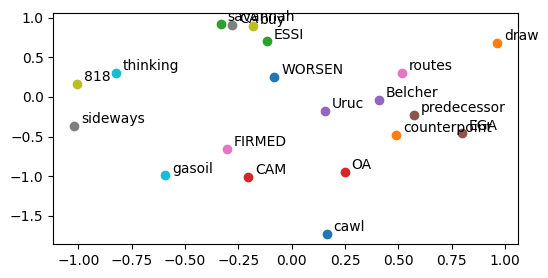

In [43]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [44]:
vocab

['cawl',
 'counterpoint',
 'savannah',
 'OA',
 'Belcher',
 'predecessor',
 'FIRMED',
 'sideways',
 'buy',
 'thinking',
 'WORSEN',
 'draw',
 'ESSI',
 'CAM',
 'Uruc',
 'EGA',
 'routes',
 'CA',
 '818',
 'gasoil',
 'pollock',
 'GIORGIO',
 'Prospects',
 'op',
 'N',
 'Sunflowerseed',
 'LEASES',
 'Morrill',
 'swine',
 'CBC',
 'Ministy',
 'Varian',
 'write',
 'TRIDENT',
 'DBS',
 'Superior',
 'Hope',
 'custom',
 'disposing',
 'JOSEPH',
 'KLU',
 'Independence',
 'NEITHER',
 'major',
 'turnovers',
 'WIRE',
 'Rampura',
 'contract',
 'NARR',
 'stealing',
 'BURR',
 'reconsider',
 'flesh',
 'Consumption',
 'Jukebox',
 'adhesives',
 'SWEDEN',
 'SENT',
 'Grange',
 'Scotsdale',
 'WJYE',
 'Comserv',
 'suit',
 'STRIKERS',
 'mineralization',
 'INSA',
 'correspond',
 'NSW',
 'RUBBERTECH',
 'Compton',
 'foreclosure',
 'gauged',
 'injunctive',
 'guardian',
 'jeopardising',
 'BRUXELLES',
 'Cavendish',
 '04',
 'Reimer',
 'religiously',
 'MPMTS',
 'PCC',
 'Preston',
 'HEPWORTH',
 'Bloch',
 'BONA',
 'flight',
 'P

In [45]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [46]:
type(cat)

tuple

In [47]:
model

Skipgram(
  (embedding_v): Embedding(41600, 2)
  (embedding_u): Embedding(41600, 2)
)

In [48]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.7564626375974635
cat vs. animal:  0.8884391369519119
cat vs. cat:  1.0


In [49]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  -0.7564626375974635
cat vs. animal:  0.8884391369519119
cat vs. cat:  1


### Save model

In [50]:
torch.save(model, './model/Word2Vec_Skipgram.pth')

### Testing

In [2]:
import torch
import numpy as np
from scipy import spatial
from sklearn.neighbors import KDTree

class AnalogyTest():
    def __init__(self, model, testfile_path, vocab):
        self.testfile_path = testfile_path
        self.model = model
        self.vocab = vocab
        self.embeddings = [self.get_embed(word) for word in vocab[:-1]]
        self.kdtree = KDTree(self.embeddings)

    def sections(self):
        section_list = []
        with open(self.testfile_path, 'r') as file:
            for line in file:
                # find capital-common-countries section
                if line.startswith(':'):
                    section = line[1:].strip()
                    section_list.append(section)
        return section_list

    def get_embed(self, word):
        if word in self.vocab[:-1]:
            id_tensor = torch.LongTensor([word2index[word]])
            v_embed = self.model.embedding_v(id_tensor)
            u_embed = self.model.embedding_u(id_tensor)
            word_embed = (v_embed + u_embed) / 2
            x, y = word_embed[0][0].item(), word_embed[0][1].item()
            return np.array([x, y])
        else:
            return None
    
    def cos_sim(self, w1, w2):
        w1 = self.get_embed(w1)
        w2 = self.get_embed(w2)
        cos_sim = 1 - spatial.distance.cosine(w1, w2)  #distance = 1 - similarlity, because scipy only gives distance
        return cos_sim

    # def test(self, model, section):
    #     total_count = 0
    #     correct_count = 0

    #     current_section = None

    #     with open(self.testfile_path, 'r') as file:
    #         for line in file:
    #             # find capital-common-countries section
    #             if line.startswith(':'):
    #                 current_section = line[1:].strip()
    #                 continue

    #             if current_section == section:
    #                 analogy = line.strip().split()
    #                 if len(analogy) != 4:
    #                     continue
    #                 w1, w2, w3, w4 = analogy

    #                 try:
    #                     infer = model.most_similar(positive=[w2, w3], negative=[w1], topn=1)
    #                     infer = infer[0][0]
    #                     total_count += 1
    #                     if infer == w4:
    #                         correct_count += 1
    #                 except KeyError as e:
    #                     print(f'"{e}" is not found in the trained vocabulary.')
        
    #     if total_count == 0:
    #         return 0
    #     accuracy = correct_count / total_count
    #     return accuracy

    def test(self, section):
        total_count = 0
        correct_count = 0
        score = 0
        i = 0
        current_section = None

        with open(self.testfile_path, 'r') as file:

            ##################
            print('Sample Inferences')
            print('='*20)    

            for line in file:
                
                # max_similarity = -1

                if line.startswith(':'):
                    current_section = line[1:].strip()
                    continue

                if current_section == section:
                    analogy = line.strip().split()
                    if len(analogy) != 4:
                        continue
                    w1, w2, w3, w4 = analogy

                    try:
                        vec_w1 = self.get_embed(w1)
                        vec_w2 = self.get_embed(w2)
                        vec_w3 = self.get_embed(w3)
                        vec_w4 = self.get_embed(w4)

                        if any(vec is None for vec in [vec_w1, vec_w2, vec_w3, vec_w4]):
                            # print('none')
                            continue 

                        vec_w4_inferred = vec_w2 + vec_w3 - vec_w1

                        # for word in self.vocab:
                            
                        #     word_vec = self.get_embed(word)
                        #     similarity = 1 - spatial.distance.cosine(word_vec, vec_w4)

                        #     if similarity > max_similarity:
                        #         max_similarity = similarity
                        #         infer = word
                        _, indices = self.kdtree.query([vec_w4_inferred], k=1)
                        infer = self.vocab[indices[0][0]]
                        
                        total_count += 1
                        if infer == w4:
                            correct_count += 1
                        similarity = max(-1, 1 - spatial.distance.cosine(self.get_embed(infer), vec_w4))
                        score += similarity

                        ################
                        while i < 3:
                            print(w1, w2, w3, w4)
                            print(vec_w1, vec_w2, vec_w3)
                            try:
                                print(f"Correct word's vector: {self.get_embed(w4)}")
                            except:
                                print(f'{w4} is not in the trained vocab')
                            print(f"Inferred vector: {self.get_embed(infer)}")
                            print(f'Inferred word: {infer}')
                            print(f'Similarity: {similarity}\n')
                            i += 1
                            break
                    except KeyError as e:
                        # print(f'"{e}" is not found in the trained vocabulary.')
                        pass     

        if total_count == 0:
            return 0
        accuracy = correct_count / total_count
        print('='*20)  
        print(f'Total test: {total_count}\nCorrect words: {correct_count}\nAccuracy: {accuracy}\nScore: {score}')
        return accuracy

In [4]:
testfile_path = './testing/word-test.v1.txt'
model = torch.load('./model/Word2Vec_Skipgram.pth')

In [55]:
analogy_test = AnalogyTest(model, testfile_path, vocab)

In [56]:
analogy_test.sections()

In [57]:
accuracy = analogy_test.test(section = 'capital-common-countries')

Sample Inferences
Athens Greece Baghdad Iraq
[ 0.86193806 -0.52121878] [ 0.65884328 -0.18398781] [-0.67540109  0.04292615]
Correct word's vector: [-1.27726448 -0.04942758]
Inferred vector: [-0.88735503  0.37410611]
Inferred word: CYACQ
Similarity: 0.9057444677365881

Athens Greece Bangkok Thailand
[ 0.86193806 -0.52121878] [ 0.65884328 -0.18398781] [ 0.41785747 -0.17280719]
Correct word's vector: [0.63337976 0.0446724 ]
Inferred vector: [0.21031186 0.1654465 ]
Inferred word: ANGELL
Similarity: 0.8275046712904544

Athens Greece Beijing China
[ 0.86193806 -0.52121878] [ 0.65884328 -0.18398781] [-0.65015638  0.50232327]
Correct word's vector: [ 1.03250062 -0.11543399]
Inferred vector: [-0.85672933  0.83361143]
Inferred word: PENNSYLVANIA
Similarity: -0.7897564403144806

none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
no

In [ ]:
accuracy = analogy_test.test(section = 'gram7-past-tense')

### Similarity testing

In [5]:
model = torch.load('./model/Word2Vec_Skipgram.pth')

In [6]:
import pickle

vocab = pickle.load(open('./vocab/word2vec_vocab.pkl', 'rb'))

In [7]:
word2index = {w: i for i, w in enumerate(vocab)}

In [8]:
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

In [9]:
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

In [13]:
from scipy.stats import spearmanr

test_performed = 0
se = 0

sim_list = []
inferred_sim_list = []

for line in open('./testing/wordsim_similarity_goldstandard.txt', 'rb'):
    if len(line.split()) != 3:
        continue
    test = line.decode('utf-8').split()
    w1, w2, sim = test
    if w1 not in vocab or w2 not in vocab:
        continue
    # transformed the scalar range from [-1, 1] to [0,10] linearly to match the range of similarity in testing file
    inferred_sim = cos_sim(get_embed(w1), get_embed(w2)) * 5 + 5 
    test_performed += 1
    se += (inferred_sim - float(sim)) ** 2
    sim_list.append(sim)
    inferred_sim_list.append(inferred_sim)

if test_performed != 0:
    mse = se / test_performed
    print(f'{test_performed} tests were performed')
    print(f'MSE: {mse}')
else:
    print('no test is performed')

print(spearmanr(sim_list, inferred_sim_list))

119 tests were performed
MSE: 18.725174017110145
SignificanceResult(statistic=-0.07360573765032674, pvalue=0.42629455780276826)


## 4. Negative Sampling

#### Unigram distribution

$$P(w)=U(w)^{3/4}/Z$$

In [59]:
Z = 0.001

In [60]:
from collections import Counter

word_count = Counter(flatten(corpus))
num_total_words = sum([c for w, c in word_count.items()])

In [61]:
word_count[',']

72360

In [62]:
num_total_words

1720917

In [63]:
unigram_table = []

for vo in vocab:
    unigram_table.extend([vo] * int(((word_count[vo]/num_total_words)**0.75)/Z))

In [64]:
Counter(unigram_table)

Counter({'.': 113,
         ',': 92,
         'the': 78,
         'of': 54,
         'to': 52,
         'in': 43,
         'said': 42,
         'and': 41,
         'a': 39,
         'mln': 32,
         'vs': 27,
         '-': 26,
         'for': 25,
         'dlrs': 23,
         "'": 23,
         'The': 22,
         '1': 21,
         '000': 21,
         's': 19,
         'pct': 19,
         ';': 19,
         'it': 19,
         '&': 18,
         'on': 18,
         'lt': 18,
         'is': 17,
         'from': 17,
         'cts': 17,
         '>': 16,
         'its': 16,
         'that': 16,
         '2': 15,
         'S': 15,
         '"': 15,
         'U': 15,
         'by': 15,
         'at': 15,
         'be': 14,
         'will': 14,
         'with': 14,
         'year': 14,
         'billion': 13,
         'was': 13,
         '3': 12,
         'loss': 11,
         'as': 11,
         'would': 11,
         'company': 11,
         '1986': 11,
         'has': 11,
         'an': 11,
   

#### Negative Sampling

In [65]:
import random

def prepare_sequence(seq, word2index):
    idxs = list(map(lambda w: word2index[w] if word2index.get(w) is not None else word2index["<UNK>"], seq))
    return torch.LongTensor(idxs)

def negative_sampling(targets, unigram_table, k):
    batch_size = targets.size(0)
    neg_samples = []
    for i in range(batch_size):
        nsample = []
        target_index = targets[i].item()
        while len(nsample) < k: # num of sampling
            neg = random.choice(unigram_table)
            if word2index[neg] == target_index:
                continue
            nsample.append(neg)
        neg_samples.append(prepare_sequence(nsample, word2index).view(1, -1))
    return torch.cat(neg_samples)

### Testing the negative sampling

In [66]:
input_batch  = torch.Tensor(input_batch)
target_batch = torch.LongTensor(target_batch)

In [67]:
target_batch.shape

torch.Size([2, 1])

In [68]:
input_batch

tensor([[ 7553],
        [29967]])

In [69]:
num_neg = 3
negative_sampling(target_batch, unigram_table, num_neg)

#{'grapes': 0, 'apple': 1, 'animal': 2, 'cat': 3, 'ice': 4, 'orange': 5, 'dog': 6, 'monkey': 7, 'conda': 8, 'fruit': 9, 'banana': 10}

tensor([[ 8911, 20209, 20102],
        [  931,  3207, 14258]])

In [70]:
target_batch[1]

tensor([35176])

### Model

$$\mathbf{J}_{\text{neg-sample}}(\mathbf{v}_c,o,\mathbf{U})=-\log(\sigma(\mathbf{u}_o^T\mathbf{v}_c))-\sum_{k=1}^K\log(\sigma(-\mathbf{u}_k^T\mathbf{v}_c))$$

In [17]:
class SkipgramNegSampling(nn.Module):

    def __init__(self, vocab_size, emb_size):
        super(SkipgramNegSampling, self).__init__()
        self.embedding_v = nn.Embedding(vocab_size, emb_size) # center embedding
        self.embedding_u = nn.Embedding(vocab_size, emb_size) # out embedding
        self.logsigmoid = nn.LogSigmoid()

    def forward(self, center_words, target_words, negative_words):
        center_embeds = self.embedding_v(center_words) # [batch_size, 1, emb_size]
        target_embeds = self.embedding_u(target_words) # [batch_size, 1, emb_size]
        neg_embeds    = -self.embedding_u(negative_words) # [batch_size, num_neg, emb_size]

        positive_score = target_embeds.bmm(center_embeds.transpose(1, 2)).squeeze(2)
        #[batch_size, 1, emb_size] @ [batch_size, emb_size, 1] = [batch_size, 1, 1] = [batch_size, 1]

        negative_score = neg_embeds.bmm(center_embeds.transpose(1, 2))
        #[batch_size, k, emb_size] @ [batch_size, emb_size, 1] = [batch_size, k, 1]

        loss = self.logsigmoid(positive_score) + torch.sum(self.logsigmoid(negative_score), 1)

        return -torch.mean(loss)

    def prediction(self, inputs):
        embeds = self.embedding_v(inputs)

        return embeds

### Training

In [72]:
batch_size     = 2 # mini-batch size
embedding_size = 2 #so we can later plot
model          = SkipgramNegSampling(voc_size, embedding_size)
num_neg        = 10 # num of negative sampling

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [73]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [74]:
import time

# Training
num_epochs = 100
for epoch in range(num_epochs):

    start = time.time()

    input_batch, target_batch = random_batch(batch_size, corpus)

    #input_batch: [batch_size, 1]
    input_batch = torch.LongTensor(input_batch)

    #target_batch: [batch_size, 1]
    target_batch = torch.LongTensor(target_batch)

    #negs_batch:   [batch_size, num_neg]
    negs_batch = negative_sampling(target_batch, unigram_table, num_neg)

    optimizer.zero_grad()

    loss = model(input_batch, target_batch, negs_batch)

    end = time.time()

    epoch_mins, epoch_secs = epoch_time(start, end)

    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch: {epoch + 1} | cost: {loss:.6f} | time: {epoch_mins}m {epoch_secs}s")


Epoch: 10 | cost: 9.570073 | time: 0m 10s
Epoch: 20 | cost: 8.237862 | time: 0m 10s
Epoch: 30 | cost: 8.184242 | time: 0m 10s
Epoch: 40 | cost: 9.486629 | time: 0m 10s
Epoch: 50 | cost: 10.344872 | time: 0m 10s
Epoch: 60 | cost: 7.994253 | time: 0m 10s
Epoch: 70 | cost: 10.875540 | time: 0m 10s
Epoch: 80 | cost: 6.941828 | time: 0m 10s
Epoch: 90 | cost: 8.635349 | time: 0m 10s
Epoch: 100 | cost: 12.890633 | time: 0m 10s


### Plotting the embeddings

In [75]:
#list of vocabs
vocab[:10]

['cawl',
 'counterpoint',
 'savannah',
 'OA',
 'Belcher',
 'predecessor',
 'FIRMED',
 'sideways',
 'buy',
 'thinking']

In [76]:
word = vocab[0]

In [77]:
#numericalization
id = word2index[word]
id

0

In [78]:
id_tensor = torch.LongTensor([id])
id_tensor

tensor([0])

In [79]:
#get the embedding by averaging
v_embed = model.embedding_v(id_tensor)
u_embed = model.embedding_u(id_tensor)

v_embed, u_embed

(tensor([[0.5589, 0.5260]], grad_fn=<EmbeddingBackward0>),
 tensor([[1.7263, 0.6161]], grad_fn=<EmbeddingBackward0>))

In [80]:
#average to get the word embedding
word_embed = (v_embed + u_embed) / 2
word_embed[0][1]

tensor(0.5710, grad_fn=<SelectBackward0>)

In [81]:
#let's write a function to get embedding given a word
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

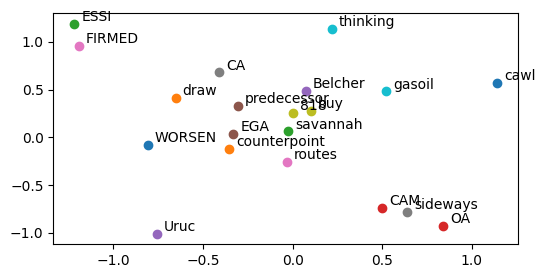

In [82]:
plt.figure(figsize=(6,3))
for i, word in enumerate(vocab[:20]): #loop each unique vocab
    x, y = get_embed(word)
    plt.scatter(x, y)
    plt.annotate(word, xy=(x, y), xytext=(5, 2), textcoords='offset points')
plt.show()

### Cosine similarity

Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

If $p$ and $q$ is super similar, the result is 1 otherwise 0.

In [83]:
vocab

['cawl',
 'counterpoint',
 'savannah',
 'OA',
 'Belcher',
 'predecessor',
 'FIRMED',
 'sideways',
 'buy',
 'thinking',
 'WORSEN',
 'draw',
 'ESSI',
 'CAM',
 'Uruc',
 'EGA',
 'routes',
 'CA',
 '818',
 'gasoil',
 'pollock',
 'GIORGIO',
 'Prospects',
 'op',
 'N',
 'Sunflowerseed',
 'LEASES',
 'Morrill',
 'swine',
 'CBC',
 'Ministy',
 'Varian',
 'write',
 'TRIDENT',
 'DBS',
 'Superior',
 'Hope',
 'custom',
 'disposing',
 'JOSEPH',
 'KLU',
 'Independence',
 'NEITHER',
 'major',
 'turnovers',
 'WIRE',
 'Rampura',
 'contract',
 'NARR',
 'stealing',
 'BURR',
 'reconsider',
 'flesh',
 'Consumption',
 'Jukebox',
 'adhesives',
 'SWEDEN',
 'SENT',
 'Grange',
 'Scotsdale',
 'WJYE',
 'Comserv',
 'suit',
 'STRIKERS',
 'mineralization',
 'INSA',
 'correspond',
 'NSW',
 'RUBBERTECH',
 'Compton',
 'foreclosure',
 'gauged',
 'injunctive',
 'guardian',
 'jeopardising',
 'BRUXELLES',
 'Cavendish',
 '04',
 'Reimer',
 'religiously',
 'MPMTS',
 'PCC',
 'Preston',
 'HEPWORTH',
 'Bloch',
 'BONA',
 'flight',
 'P

In [84]:
#let's try similarity between first and second, and second and third
cat          = get_embed('cat')
fruit        = get_embed('fruit')
animal       = get_embed('animal')

In [85]:
#numpy version
from numpy import dot
from numpy.linalg import norm

def cos_sim(a, b):
    cos_sim = dot(a, b)/(norm(a)*norm(b))
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.5139733752407668
cat vs. animal:  0.9441702214618698
cat vs. cat:  1.0000000000000002


In [86]:
#scipy version
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

print(f"cat vs. fruit: ",        cos_sim(cat, fruit))
print(f"cat vs. animal: ",       cos_sim(cat, animal))
print(f"cat vs. cat: ",          cos_sim(cat, cat))

cat vs. fruit:  0.5139733752407668
cat vs. animal:  0.9441702214618698
cat vs. cat:  1


### Save model 

In [87]:
torch.save(model, './model/Word2Vec_Negative Sampling.pth')

### Testing

In [88]:
testfile_path = './testing/word-test.v1.txt'
model = torch.load('./model/Word2Vec_Negative Sampling.pth')
analogy_test = AnalogyTest(model, testfile_path, vocab)

In [89]:
accuracy = analogy_test.test(section = 'capital-common-countries')
accuracy

Sample Inferences
Athens Greece Baghdad Iraq
[-0.64429891 -0.57957435] [-0.14083549  0.12334841] [-0.99600542  0.32385665]
Correct word's vector: [-0.13086712 -1.42213166]
Inferred vector: [-0.48920825  1.01149178]
Inferred word: kilometer
Similarity: -0.8565518534159766

Athens Greece Bangkok Thailand
[-0.64429891 -0.57957435] [-0.14083549  0.12334841] [-0.30434436  1.22509313]
Correct word's vector: [-0.02153754 -0.25794309]
Inferred vector: [0.21393836 1.89723134]
Inferred word: Hess
Similarity: -0.999579961818164

Athens Greece Beijing China
[-0.64429891 -0.57957435] [-0.14083549  0.12334841] [-0.38644078 -1.16227078]
Correct word's vector: [0.08588266 0.15427765]
Inferred vector: [ 0.12257886 -0.45694479]
Inferred word: OPEN
Similarity: -0.7178819359533075

none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
no

0.0

In [90]:
accuracy = analogy_test.test(section = 'gram7-past-tense')
accuracy

Sample Inferences
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
none
decreasing decreased describing described
[-0.51566958  1.08132815] [1.55060196 0.13061261] [1.15213871 0.66272402]
Correct word's vector: [ 0.67960691 -0.58825958]
Inferred vector: [ 2.76058435 -0.16699132]
Inferred word: MASSACHUSETTS
Similarity: 0.7942302115403761

decreasing decreased enhancing enhanced
[-0.51566958  1.08132815] [1.55060196 0.13061261] [ 0.14803702 -0.65229023]
Correct word's vector: [0.31151956 0.77647996]
Inferred vector: [ 2.23345184 -1.52075112]
Inferred word: MTMA
Similarity: -0.21457252694181062

decreasing decreased falling fell
[-0.51566958  1.08132815] [1.55060196 0.13061261] [-0.18643504 -0.31454763]
Correct word's vector: [-0.10599096  0.20421183]
Inferred vector: [ 1.86534679 -1.19980049]
Inferred word: 597
Similarity: -0.8675897661736274

none

0.0

### Similarity testing

In [18]:
model = torch.load('./model/Word2Vec_Negative Sampling.pth')

In [19]:
import pickle

vocab = pickle.load(open('./vocab/word2vec_vocab.pkl', 'rb'))

In [20]:
word2index = {w: i for i, w in enumerate(vocab)}

In [21]:
def get_embed(word):
    id_tensor = torch.LongTensor([word2index[word]])
    v_embed = model.embedding_v(id_tensor)
    u_embed = model.embedding_u(id_tensor)
    word_embed = (v_embed + u_embed) / 2
    x, y = word_embed[0][0].item(), word_embed[0][1].item()

    return x, y

In [22]:
from scipy import spatial

def cos_sim(a, b):
    cos_sim = 1 - spatial.distance.cosine(a, b)  #distance = 1 - similarlity, because scipy only gives distance
    return cos_sim

In [23]:
from scipy.stats import spearmanr

test_performed = 0
se = 0

sim_list = []
inferred_sim_list = []

for line in open('./testing/wordsim_similarity_goldstandard.txt', 'rb'):
    if len(line.split()) != 3:
        continue
    test = line.decode('utf-8').split()
    w1, w2, sim = test
    if w1 not in vocab or w2 not in vocab:
        continue
    # transformed the scalar range from [-1, 1] to [0,10] linearly to match the range of similarity in testing file
    inferred_sim = cos_sim(get_embed(w1), get_embed(w2)) * 5 + 5 
    test_performed += 1
    se += (inferred_sim - float(sim)) ** 2
    sim_list.append(sim)
    inferred_sim_list.append(inferred_sim)

if test_performed != 0:
    mse = se / test_performed
    print(f'{test_performed} tests were performed')
    print(f'MSE: {mse}')
else:
    print('no test is performed')

print(spearmanr(sim_list, inferred_sim_list))

119 tests were performed
MSE: 16.741569400401747
SignificanceResult(statistic=-0.03804921658411907, pvalue=0.6811930825429193)
